### PRESIDENTIAL ELECTION PREDICTION

#### Importing Neccessary Libraries

In [1]:
#pip install plotly
#pip install genesim


In [2]:
# importing the libraries that we will need
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
import os
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/captain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Merging all csv into one big csv

In [3]:
#
path = "./MY DATA_ADDED"
files = [file for file in os.listdir(path) if not file.startswith('.')]

all_data = pd.DataFrame()
for file in files:
    current_data = pd.read_csv(path+"/"+file,low_memory =False
)


    all_data = pd.concat([all_data, current_data])

all_data.to_csv("President.csv")



### Loading Dataset

In [4]:
df = pd.read_csv("President.csv")
df.head()


/tmp/ipykernel_69090/1165560949.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("President.csv")


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0      tweet_id  \
0             0           0.0           0  1.555224e+18   
1             1           1.0           1  1.555222e+18   
2             2           2.0           2  1.555222e+18   
3             3           3.0           3  1.555222e+18   
4             4           4.0           4  1.555220e+18   

                        time  \
0  2022-08-04 16:08:18+00:00   
1  2022-08-04 16:00:18+00:00   
2  2022-08-04 16:00:17+00:00   
3  2022-08-04 15:59:14+00:00   
4  2022-08-04 15:51:49+00:00   

                                               tweet  retweet_count User  \
0  RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...          252.0  NaN   
1  RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...          252.0  NaN   
2  RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...          252.0  NaN   
3  RT @chato_emma: @nedum030 The then real @MBuha...            1.0  NaN   
4  RT @aminurus: Can any man can fight God and wi...          108.0  NaN   

  Date_Created Source of Tweet Tweet  
0          NaN             NaN   NaN  
1          NaN             NaN   NaN  
2          NaN             NaN   NaN  
3          NaN             NaN   NaN  
4          NaN             NaN   NaN

## Preview of our Dataset

In [5]:
# function to preview the dataframe preview dataframe
def preview_df(df):
    head = df.head()
    tail = df.tail()
    random_sample = df.sample(30)
    rows, columns = df.shape

    return head, tail, random_sample, print(f"THe dataframe has {rows} rows and {columns} columns")


In [6]:
# preview shape of datframe
rows, columns = df.shape

# print
print(f"THe dataframe has {rows} rows and {columns} columns")

THe dataframe has 918779 rows and 11 columns


In [7]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'tweet_id', 'time',
       'tweet', 'retweet_count', 'User', 'Date_Created', 'Source of Tweet',
       'Tweet'],
      dtype='object')

### Our dataset has a total of 918779 entries. The columns that we  are going to use are Tweet_id, Date, Tweet, and Retweet_count.
**we are going to drop the remaining column because we do not need them in our analysis**


In [8]:
cols_to_drop = ['Unnamed: 0','Unnamed: 0.1',' Unnamed: 0.2 ','User','Date_Created','Source of Tweet','Tweet']
df = df[[col for col in df.columns if not col in cols_to_drop]]

df.head()

Unnamed: 0.2      tweet_id                       time  \
0             0  1.555224e+18  2022-08-04 16:08:18+00:00   
1             1  1.555222e+18  2022-08-04 16:00:18+00:00   
2             2  1.555222e+18  2022-08-04 16:00:17+00:00   
3             3  1.555222e+18  2022-08-04 15:59:14+00:00   
4             4  1.555220e+18  2022-08-04 15:51:49+00:00   

                                               tweet  retweet_count  
0  RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...          252.0  
1  RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...          252.0  
2  RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...          252.0  
3  RT @chato_emma: @nedum030 The then real @MBuha...            1.0  
4  RT @aminurus: Can any man can fight God and wi...          108.0

### Checking for missing Values

In [9]:
# checking if there are any missing values in the dataset
df.isnull().sum()


Unnamed: 0.2         0
tweet_id          3001
time              3001
tweet             3001
retweet_count    45085
dtype: int64

In [10]:
# finding the percentage of missing values for each column
percent_missing = round(df.isnull().sum() * 100 / len(df),2)
percent_missing


Unnamed: 0.2     0.00
tweet_id         0.33
time             0.33
tweet            0.33
retweet_count    4.91
dtype: float64

In [11]:
# finding the percentage of missing values for the entire dataset
percentage_missing = round(df.isnull().sum().sum() * 100 / len(df),2)
percentage_missing


5.89

### Dopping Missing Values

### Our dataset contains missing values, for each columns this is how we will sort it out

* **tweet_id**: *We will drop the missing values since this is a unique identifier, and you cannot impute it. It should be generated from Twitter.*

* **time**: *We will impute the missing values using backfill.*

* **tweet**: *We will drop the missing values here, since the tweet is the sentiment shared by an individual.*

* **retweet_count**: *We will fill the missing values with '0.*

In [12]:
# forward filling and backward filling the missing dates

df['time'] = df['time'].ffill().bfill()

In [13]:
# filling missing values in retweet_count column with '0'

df['retweet_count'] = df['retweet_count'].fillna(0)

In [14]:
# Dropping missing values in tweet_id

df.dropna(subset=['tweet_id'], inplace=True)

# by dropping the missing values in tweet_id, tweets with missing values also got dropped

In [15]:
# Checking to see if missing values have been resolved

df.isnull().sum()

Unnamed: 0.2     0
tweet_id         0
time             0
tweet            0
retweet_count    0
dtype: int64

**WE HAVE SUCCESSFULLY DROP ALL NULL VALUES**

### Preprocessing tweets

**Here we are going to  remove the special characters, convert texts to lower case, remove unnecessary links and images in order to make the tweets more easy to analyse**


In [16]:

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('#([A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    return tweet

def tokenize_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['tokens'] = df.tweet.apply(preprocess_tweet)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df



In [17]:
# applying preprocessings to the tweet
df['tweet_clean'] = df['tweet'].apply(preprocess_tweet)


In [18]:
# sampling five tweets to see the 
df.sample(5)

Unnamed: 0.2      tweet_id                       time  \
665151        105128  1.555495e+18  2022-08-05 10:06:14+00:00   
785152        225129  1.555845e+18  2022-08-06 09:16:17+00:00   
430229           787  1.554055e+18  2022-08-01 10:42:10+00:00   
392279        344569  1.553829e+18  2022-07-31 19:42:58+00:00   
144750         97040  1.553336e+18  2022-07-30 11:05:11+00:00   

                                                    tweet  retweet_count  \
665151  RT @johnnysleek: Shame they actually thought t...           50.0   
785152  RT @David__Osland: Wildcat strike at non-union...          443.0   
430229  RT @TinubuOnDStreet: The best men coming toget...           52.0   
392279  RT @aminurus: The propaganda is taking a new d...         3988.0   
144750  RT @firstladyship: Anambra is APGA for guber, ...         2526.0   

                                              tweet_clean  
665151  shame actually think picture rahman jago tinub...  
785152  wildcat strike non union amazon fulfilment cen...  
430229  best men come country promise land combination...  
392279  propaganda take new dimension peter obi candid...  
144750  anambra apga guber federal jos shout peter obi...


## Data Validity

**CONVERTING RESPECTIVE COLUMNS TO APPROPRIATE DATA TYPES**


In [19]:
# changing the datatype of retweet_count and time to their respective datatypes
df['retweet_count'] = df['retweet_count'].astype('int')
df['time'] = pd.to_datetime(df['time'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 915778 entries, 0 to 918778
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   Unnamed: 0.2   915778 non-null  int64              
 1   tweet_id       915778 non-null  float64            
 2   time           915778 non-null  datetime64[ns, UTC]
 3   tweet          915778 non-null  object             
 4   retweet_count  915778 non-null  int64              
 5   tweet_clean    915778 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 48.9+ MB


### Checking for duplicates in our Dataset

In [20]:
# checking if we have duplicates in our 'tweet_id' column since it is out unique identifier


In [21]:
#dropping the duplicates in the tweet_id column
df.drop_duplicates()


Unnamed: 0.2      tweet_id                      time  \
0                  0  1.555224e+18 2022-08-04 16:08:18+00:00   
1                  1  1.555222e+18 2022-08-04 16:00:18+00:00   
2                  2  1.555222e+18 2022-08-04 16:00:17+00:00   
3                  3  1.555222e+18 2022-08-04 15:59:14+00:00   
4                  4  1.555220e+18 2022-08-04 15:51:49+00:00   
...              ...           ...                       ...   
918774        358751  1.554585e+18 2022-08-02 21:49:58+00:00   
918775        358752  1.554585e+18 2022-08-02 21:49:58+00:00   
918776        358753  1.554585e+18 2022-08-02 21:49:57+00:00   
918777        358754  1.554585e+18 2022-08-02 21:49:55+00:00   
918778        358755  1.554585e+18 2022-08-02 21:49:38+00:00   

                                                    tweet  retweet_count  \
0       RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...            252   
1       RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...            252   
2       RT @EmekaGift100: Mazi Nnamdi Kanu in his prev...            252   
3       RT @chato_emma: @nedum030 The then real @MBuha...              1   
4       RT @aminurus: Can any man can fight God and wi...            108   
...                                                   ...            ...   
918774  RT @PeterPsquare: Happy birthday @PeterObi  As...           2139   
918775  RT @OpeyemiAyoola01: I am a Lagosian. In my st...            872   
918776  @Oyinkitana God bless you all obidient family ...              0   
918777  @goreehollar1 @ritzyken @firstladyship Oga shu...              0   
918778  RT @Iamemmanuelaig: Grateful for quality camer...              1   

                                              tweet_clean  
0       mazi nnamdi kanu previous broadcast say dead m...  
1       mazi nnamdi kanu previous broadcast say dead m...  
2       mazi nnamdi kanu previous broadcast say dead m...  
3       real support haram say kill boko haram fighter...  
4       man fight god win candidate win presidential e...  
...                                                   ...  
918774  happy birthday celebrate year remember happine...  
918775      lagosian street address anymore obidient love  
918776               god bless obidient family follow bac  
918777                            oga shut tread obidient  
918778   grateful quality cameras ability obidient yusful  

[915776 rows x 6 columns]

In [22]:
# checking for duplicate in cleaned tweets
duplicate_tweets  = df['tweet_clean'].duplicated().sum()

# print duplicate tweet numbers
print(f'''
There are {duplicate_tweets} duplicate tweets in the dataset after cleaning. 
They shall be dropped maintaining only the last tweet
''')


There are 788627 duplicate tweets in the dataset after cleaning. 
They shall be dropped maintaining only the last tweet



In [23]:
# dropping the duplicates in the tweet_clean column keeping last
df.drop_duplicates(subset=['tweet_clean'], keep='last', inplace=True)


In [24]:
# confirm for any remaining duplicate records remaining
duplicate_tweets  = df['tweet_clean'].duplicated().sum()

# print duplicate tweet numbers
print(f'''
There are {duplicate_tweets} duplicate tweets in the dataset after cleaning. 
''')



There are 0 duplicate tweets in the dataset after cleaning. 



In [25]:
# shape of dataframe after dealing with duplicate tweets and missing values
rows1, columns1 = df.shape

# printing
print(f'''
The dataframe has {rows1} remaining records and {columns1} remaining columns. 
There has been a lose of {((rows-rows1)/ rows) * 100}% of all records
''')


The dataframe has 127151 remaining records and 6 remaining columns. 
There has been a lose of 86.16087220104073% of all records



### Feature Engineering

**Here we will create new columns that will contain the subjectivity and polarity of the tweets**

In [26]:
# Creating a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Creating a function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Creating two additional columns to check the Subjectivity and Polarity
df['Subjectivity'] = df['tweet_clean'].apply(getSubjectivity)
df['Polarity'] = df['tweet_clean'].apply(getPolarity)

# Previewing random samples of five records
df.sample(5)

Unnamed: 0.2      tweet_id                      time  \
707219        147196  1.555507e+18 2022-08-05 10:51:00+00:00   
364562        316852  1.553666e+18 2022-07-31 08:57:10+00:00   
727495        167472  1.555752e+18 2022-08-06 03:06:05+00:00   
705680        145657  1.555517e+18 2022-08-05 11:33:12+00:00   
11231          11231  1.555204e+18 2022-08-04 14:48:49+00:00   

                                                    tweet  retweet_count  \
707219  Anyone who is still campaigning or selling APC...              0   
364562  @Imudia_se2 @okem_iyeep I thought @atiku said ...              0   
727495  @fkeyamo @officialABAT @KashimSM No party does...              0   
705680  @BashirAhmaad No body os dragging ur president...              0   
11231   @OYEBRIGHT @Qdpaper2 So all the floods in Lago...              0   

                                              tweet_clean  Subjectivity  \
707219  campaign sell apc nigerians shameless feel fre...      0.800000   
364562      think say brothers sisters north social media      0.066667   
727495                                    party wait thei      0.000000   
705680  body drag presidential candidates bat remain a...      0.070833   
11231        flood lagos tinubu mismanagement away reason      0.000000   

        Polarity  
707219  0.400000  
364562  0.033333  
727495  0.000000  
705680 -0.100000  
11231   0.000000

In [27]:
# finding the various aspirants participating in the 2023 Nigeria general elections
the_list = ['tinubu','batified', 'peter obi', 'obi' , 'atiku','obidient','tinubu atiku']

def aspirant_finder(string):
    term_return = 'None'
    for term in the_list:
        if term in string:
            term_return = term
    return term_return

# party finder: Find the various coalitions in 2022 Nigeria general election
the_list1 = [ 'apc','pdp','labour party','lp','apc pdp','pdp apc']

def Party_finder(string):
    term_return = 'None'
    for term in the_list1:
        if term in string:
            term_return = term
    return term_return

In [28]:
# applying the finder function to find the various aspirant
df['presidential_aspirant'] = df['tweet_clean'].apply(aspirant_finder)

# Replacing the various names used to refer to top preseidential contenders with their oficial names
df =df.replace({'presidential_aspirant' : { 'tinubu' : 'Tinubu', 'peter obi':'PeterObi', 'obi' : 'PeterObi', 'atiku' : 'Atiku','obidient':'PeterObi','batified':'Tinubu','bola':'Tinubu','tinubu atiku':'Tinubu'}})

# Sampling 10 records
df.sample(30)

Unnamed: 0.2      tweet_id                      time  \
669202        109179  1.552947e+18 2022-07-29 09:20:57+00:00   
259751        212041  1.553058e+18 2022-07-29 16:41:41+00:00   
545548         73682  1.555545e+18 2022-08-05 13:23:48+00:00   
335646        287936  1.553837e+18 2022-07-31 20:18:07+00:00   
8401            8401  1.555170e+18 2022-08-04 12:32:59+00:00   
243628        195918  1.553700e+18 2022-07-31 11:12:26+00:00   
197722        150012  1.553836e+18 2022-07-31 20:11:04+00:00   
276449        228739  1.551790e+18 2022-07-26 04:41:30+00:00   
130329         82619  1.553463e+18 2022-07-30 19:28:18+00:00   
323214        275504  1.553634e+18 2022-07-31 06:48:43+00:00   
437390          7948  1.553317e+18 2022-07-30 09:51:44+00:00   
638854         78831  1.555638e+18 2022-08-05 19:33:32+00:00   
274608        226898  1.551968e+18 2022-07-26 16:29:49+00:00   
860217        300194  1.555590e+18 2022-08-05 16:20:14+00:00   
360875        313165  1.553685e+18 2022-07-31 10:10:41+00:00   
745971        185948  1.555544e+18 2022-08-05 13:17:41+00:00   
817013        256990  1.555468e+18 2022-08-05 08:17:12+00:00   
716607        156584  1.555441e+18 2022-08-05 06:28:23+00:00   
359302        311592  1.553694e+18 2022-07-31 10:46:45+00:00   
251972        204262  1.553425e+18 2022-07-30 17:00:04+00:00   
894871        334848  1.555304e+18 2022-08-04 21:26:57+00:00   
529400         57534  1.552154e+18 2022-07-27 04:48:24+00:00   
143203         95493  1.553345e+18 2022-07-30 11:42:48+00:00   
669005        108982  1.553336e+18 2022-07-30 11:05:55+00:00   
331614        283904  1.553860e+18 2022-07-31 21:48:06+00:00   
368977        321267  1.553644e+18 2022-07-31 07:30:51+00:00   
225298        177588  1.553747e+18 2022-07-31 14:19:18+00:00   
97422          49712  1.552261e+18 2022-07-27 11:54:44+00:00   
314171        266461  1.553694e+18 2022-07-31 10:48:42+00:00   
791095        231072  1.555763e+18 2022-08-06 03:50:37+00:00   

                                                    tweet  retweet_count  \
669202  Tho I'm Atikulated, but seriously, what's wron...              0   
259751  @Joshogbonna2 @PeterObi @NgLabour I agree with...              0   
545548  In clearing containers.\nNow we have seen the ...              0   
335646  @emmaikumeh "Resolve to remain in PDP" not the...              1   
8401    @Gagarute @thebardogbamola @OfficialPDPNig I D...              0   
243628  @olasodiq604 @Quazim11 @streakme03 @fkeyamo @o...              0   
197722  @ibrahimolawoye @SavvyRinu @SmallAlhaji_ @Aaji...              0   
276449  Today is Tuesday 26th July 2022. Peter Obi and...              0   
130329  @von_Bismack @OkonkwoOnyekac2 I don’t like PDP...              0   
323214  RT @RBiakpara: The insensitive reaction to the...             21   
437390  RT @OfficialPDPNig: 2023: #DidYouKnow that und...             92   
638854  @OsosaChris Tinubu has a brain brand? Of cos t...              0   
274608  This is why you don’t just have to be an onlin...              0   
860217  @KawuGarba @el_uthmaan And yet they want us to...              0   
360875  RT @MazihJr: They don't know that this is not ...              1   
745971  @ugwuanyi_ekene @adeyanjudeji Please stop usin...              0   
817013  @AngelaRayner Let’s be honest the Labour Party...              0   
716607  @Omega0803 @FS_Yusuf_ 😂😂😂😂 look at who's calli...              0   
359302  @OLUWAGEEZIE77 @SeaJustified @Elkrosmediahub A...              1   
251972  @ChigozieIAlex @NgLabour Oga you are showing u...              0   
894871  @jingiguy @Sadiqsans @Kinglupper I watched one...              0   
529400           @WESTCURATOR_ Batified space I greet una              0   
143203  2023: Okowa Embarks on Shuttle Diplomacy, Call...              0   
669005  @_kiriiku 100k will surely go a very long way ...              0   
331614  @AfamDeluxo Bro,you are not saying it loud eno...              0   
368977  @DanielRegha @PeterObi @DunamisGospel @

In [29]:
# applying the Party finder function
df['Party'] = df['tweet_clean'].apply(Party_finder)

# Renaming the various party mentions and the various terms used to refer to coalitions and 
# party by the general pulic with the official names of the Party they belong to
df =df.replace({'Party' : { 'apc':'APC','pdp':'PDP','labour party':'Labour Party','apc pdp':'APC','pdp apc':'pdp','lp':'Labour Party'}})

# Sampling 10 records
df.sample(30)


Unnamed: 0.2      tweet_id                      time  \
806945        246922  1.555563e+18 2022-08-05 14:35:13+00:00   
622769         62746  1.555799e+18 2022-08-06 06:12:31+00:00   
802800        242777  1.555595e+18 2022-08-05 16:41:20+00:00   
735953        175930  1.555616e+18 2022-08-05 18:07:17+00:00   
299900        252190  1.553808e+18 2022-07-31 18:19:42+00:00   
815198        255175  1.555491e+18 2022-08-05 09:48:20+00:00   
643094         83071  1.555613e+18 2022-08-05 17:54:14+00:00   
625077         65054  1.555782e+18 2022-08-06 05:06:46+00:00   
302570        254860  1.553785e+18 2022-07-31 16:48:29+00:00   
823723        263700  1.555826e+18 2022-08-06 08:01:21+00:00   
139441         91731  1.553375e+18 2022-07-30 13:42:25+00:00   
14313          14313  1.555178e+18 2022-08-04 13:03:30+00:00   
382582        334872  1.553847e+18 2022-07-31 20:55:18+00:00   
752763        192740  1.555492e+18 2022-08-05 09:52:34+00:00   
746950        186927  1.555536e+18 2022-08-05 12:48:03+00:00   
656844         96821  1.555540e+18 2022-08-05 13:03:53+00:00   
868568        308545  1.555555e+18 2022-08-05 14:02:13+00:00   
366160        318450  1.553659e+18 2022-07-31 08:27:23+00:00   
329343        281633  1.553880e+18 2022-07-31 23:08:49+00:00   
680080        120057  1.555693e+18 2022-08-05 23:10:35+00:00   
373309        325599  1.553621e+18 2022-07-31 05:58:09+00:00   
425370        377660  1.553772e+18 2022-07-31 15:57:05+00:00   
117394         69684  1.553676e+18 2022-07-31 09:35:00+00:00   
202773        155063  1.553819e+18 2022-07-31 19:05:44+00:00   
563890          3867  1.553519e+18 2022-07-30 23:11:06+00:00   
656094         96071  1.555544e+18 2022-08-05 13:19:56+00:00   
661591        101568  1.555514e+18 2022-08-05 11:20:30+00:00   
297261        249551  1.553828e+18 2022-07-31 19:42:34+00:00   
267615        219905  1.552669e+18 2022-07-28 14:55:13+00:00   
909286        349263  1.554876e+18 2022-08-03 17:06:20+00:00   

                                                    tweet  retweet_count  \
806945  @BjCruickshank @Anna_Soubry She's not in the L...              0   
622769  Unfortunate beings will vote for Tinubu after ...              0   
802800  RT @4207Ellen: @EssexLad_36 @RonNewm72135826 @...              1   
735953  @AnthonyEhilebo @atiku LoL 😂😂 are they the one...              0   
299900  @Meeerah_aa @zaMusbeyNe_ Share us his Twitter ...              0   
815198  Demand for book Truth Only Triumphs Book which...              0   
643094  @emmaikumeh @MalachyOdo1 This is a fact. Tinub...              0   
625077  Festus Keyamo - Parents should go and beg ASUU...             87   
302570  Some Nigerians have dragged Nollywood veteran,...              0   
823723  Guy I weep when I see tweet like this😭😭😭 you w...              0   
139441  @Victorychi2 @Anyim_Anyim @woye1 Shot time app...              0   
14313   @CynthiaIgobah As at today I’m for PO but the ...              0   
382582  RT @Piux_P: If given the opportunity, Peter Ob...              1   
752763  @TheNationNews I think  Atiku is making  the s...              0   
746950  @IAOkowa,@atiku will porkect you &amp; he will...              2   
656844  RT @Lurdfab: Read carefully and vote PETER OBI...              1   
868568  RT @renoomokri: I don’t get this Peter Obi’s o...            244   
366160  @atiku And one of the objectives is to be Obid...              0   
329343  RT @Atikukawaikano1: *Today (31/07/2022), ATIK...              4   
680080         @channelstv APC is winning 2023 presidency              0   
373309  @JohnFanimokun @atiku @PeterObi how many peopl...              0   
425370  RT @O_ssai: You are under every giveaway tweet...             19   
117394  @El_Technologies @ayemojubar @thedichotome @fi...              0   
202773  RT @Excel22300814: @ozzyetomi It was Asiwaju T...              2   
563890  @zico_denni @official_X_ @drpenking @PeterObi ...              0   
656094  @DeeOneAyekooto be confusing urself....

### Downloading DataFrame

We will use the cleaned and feature engineered dataframe in our streamlit ui

In [30]:

#df.to_csv('elections_df.csv') 


### Exploratory Data Analysis

In [31]:
#Creating copy of cleaned dataframe
df1 = df.copy()


## Word popularity 

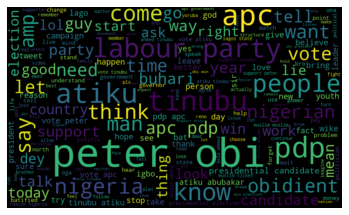

In [32]:
# Plotting Word Cloud 
allWords = ' '.join([twts for twts in df['tweet_clean']])
wordCloud = WordCloud(width = 1000, height = 600, random_state = 12, max_font_size = 119).generate(allWords)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the Twwets'}, xlabel='bigram'>

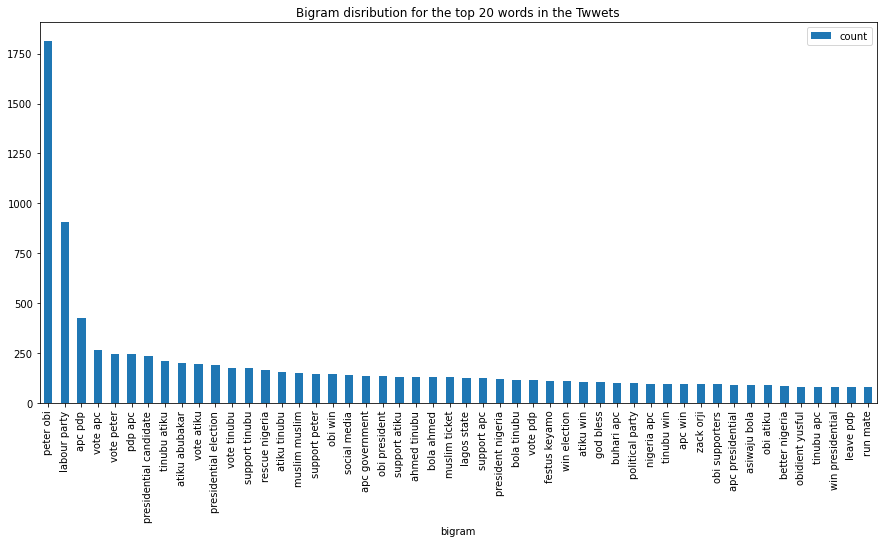

In [33]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df1['tweet_clean'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True)
 
#Taking first 20 records
words1 = bigram.head(50)

#Plotting the bigram distribution
words1.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the Twwets", figsize = (15,7), )


## Word Popularity in Percentage -Presidential Aspirants 

In [34]:
# Applying aspirant finder function
words1['presidential_aspirant'] = words1['bigram'].apply(aspirant_finder)


/tmp/ipykernel_69090/1388611842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words1['presidential_aspirant'] = words1['bigram'].apply(aspirant_finder)


In [35]:
# Replacing the various names used to refer to top preseidential contenders with their oficial names
words_clean =words1.replace({'presidential_aspirant' : { 'tinubu' : 'Tinubu','obi' : 'peterObi','atiku':'ATIKU','tinubu atiku':'Tinubu','obidient':'peterObi'}})

# Dropping the now irrelevant bigram column
words_presidents = words_clean.drop('bigram', axis = 1)

# Group the records based on the presidential aspirants
words_president = words_presidents.groupby('presidential_aspirant',  as_index=False, sort=False).agg({'count': 'sum'})

# Drop records that have no mention of the presidential aspirant
words_president.drop(words_president.loc[words_president['presidential_aspirant']== 'None'].index, inplace=True)

# Get a count of the mentions of the presidential aspirants as a percentage
words_president['count'] = (words_president['count']/ words_president['count'].sum()) * 100
words_president


presidential_aspirant      count
0              peterObi  54.953493
2                Tinubu  23.796763
3                 ATIKU  21.249744

### Word popularity - By Party in percentage

In [36]:
# applying the coalition finder function
words1['Party'] = words1['bigram'].apply(Party_finder)


/tmp/ipykernel_69090/2671790792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words1['Party'] = words1['bigram'].apply(Party_finder)


In [37]:
# Renaming the various party mentions and the various terms used to refer to Parties and 
# partys by the general pulic with the official names of the colaitions they belong to
words_clean =words1.replace({'Party' : { 'apc': 'APC', 'labour party': 'Labour party', 'pdp': 'PDP','apc pdp':'APC', 'pdp apc':'PDP'}})

# Dropping the now irrelevant bigram column
words_partys = words_clean.drop('bigram', axis = 1)

# groupning the records based on coalitions
words_party = words_partys.groupby('Party',  as_index=False, sort=False).agg({'count': 'sum'})

# Dropping all records without a mention of a party in the tweet
words_party.drop(words_party.loc[words_party['Party']== 'None'].index, inplace=True)

# Finding the mentions per coalition in percentage format
words_party['count'] = (words_party['count']/ words_party['count'].sum()) * 100

# output
words_party


Party      count
1  Labour party  32.851953
2           APC  51.329930
3           PDP  15.818118

In [38]:
# Creating dataframe subsets with tweets containing information on of the various presidential aspirants

# Dataset containing peterObi's mentions
df_peterObi = df1 [df1 ['presidential_aspirant'] == 'PeterObi']

# Dataset containing Tinubu's mentions
df_Tinubu = df1 [df1 ['presidential_aspirant'] == 'Tinubu']

# Dataset containing ATIKU's mentions
df_ATIKU = df1 [df1 ['presidential_aspirant'] == 'Atiku']




### Polarity - assignements

Assigning sentiments as positive negative or neutral

**Note**

**Polarity > 0      = Positive sentiment**

**Polarity < 0      = Negative sentiment**

**Polarity == 0     = Neutral sentiment**


In [39]:
# Assigning values greater than zero with positive sentiment less than zero negative sentiment
df_peterObi['Expressions'] = np.where(df_peterObi['Polarity'] > 0, 'Positive', 'Negative')

# Assigning sentiniments with polarity of zero neutral sentiment
df_peterObi.loc[df_peterObi.Polarity == 0, 'Expressions'] = 'Neutral'

# Assigning values greater than zero with positive sentiment less than zero negative sentiment
df_Tinubu['Expressions'] = np.where(df_Tinubu['Polarity'] > 0, 'Positive', 'Negative')

# Assigning sentiniments with polarity of zero neutral sentiment
df_Tinubu.loc[df_Tinubu.Polarity == 0, 'Expressions'] = 'Neutral'

# Assigning values greater than zero with positive sentiment less than zero negative sentiment
df_ATIKU['Expressions'] = np.where(df_ATIKU['Polarity'] > 0, 'Positive', 'Negative')

# Assigning sentiniments with polarity of zero neutral sentiment
df_ATIKU.loc[df_ATIKU.Polarity == 0, 'Expressions'] = 'Neutral'


/tmp/ipykernel_69090/91218543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peterObi['Expressions'] = np.where(df_peterObi['Polarity'] > 0, 'Positive', 'Negative')
/tmp/ipykernel_69090/91218543.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Tinubu['Expressions'] = np.where(df_Tinubu['Polarity'] > 0, 'Positive', 'Negative')
/tmp/ipykernel_69090/91218543.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

### Polarity-Histogram Plot

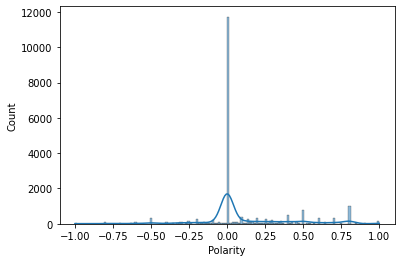

In [40]:
# Plotting a distribution of polarity of sentiments towards peterObi
sns.histplot(data=df_peterObi, x="Polarity", kde=True)

# Showing plot
plt.show()


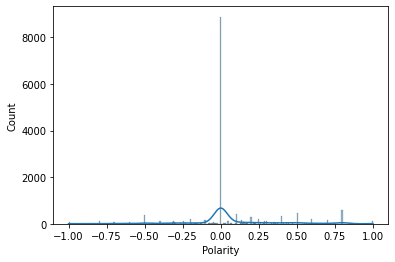

In [41]:
# Plotting a distribution of polarity of sentiments towards raila
sns.histplot(data=df_Tinubu, x="Polarity", kde=True)

# Showing plot
plt.show()



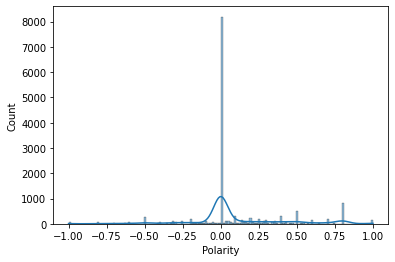

In [42]:
# Plotting a distribution of polarity of sentiments towards raila
sns.histplot(data=df_ATIKU, x="Polarity", kde=True)

# Showing plot
plt.show()

**From the visuals of the three presidential aspirants it is evident that most of the sentiments with their mentions are neutral**

### Polarity Counts

In [43]:
# Printing out the number of records that have neutral sentiments in the different presidential datasets
print(df_peterObi[df_peterObi['Polarity']==0].shape)
print(df_Tinubu[df_Tinubu['Polarity']==0].shape)
print(df_ATIKU[df_ATIKU['Polarity']==0].shape)



(11702, 11)
(8870, 11)
(8177, 11)


**The dataframe with tweets that mentioned PETEROBI has the most neutral sentiments, while ATIKU has the least neutral sentiments**

In [44]:
# printing out records with positive sentiments  in the different presidential datasets
print(df_peterObi[df_peterObi['Polarity']>0].shape)
print(df_Tinubu[df_Tinubu['Polarity']>0].shape)
print(df_ATIKU[df_ATIKU['Polarity']>0].shape)


(6856, 11)
(4487, 11)
(4630, 11)


**From the result above, PETEROBI is the presidential aspirant with the most number of positive sentiments by social media users. TINUBU has the least number of positive sentiments**

<AxesSubplot:xlabel='Expressions', ylabel='count'>

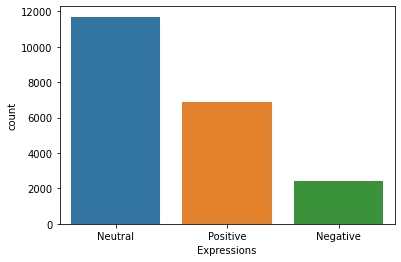

In [45]:
import seaborn
seaborn.countplot(x='Expressions',data=df_peterObi)

<AxesSubplot:xlabel='Expressions', ylabel='count'>

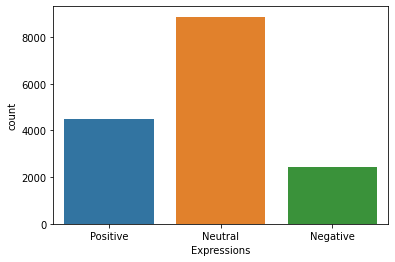

In [46]:

seaborn.countplot(x='Expressions',data=df_Tinubu)

<AxesSubplot:xlabel='Expressions', ylabel='count'>

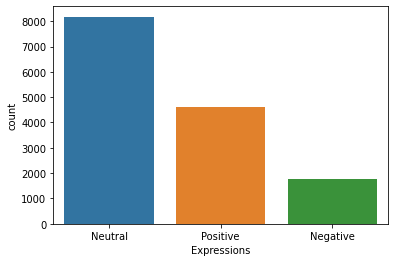

In [47]:
seaborn.countplot(x='Expressions',data=df_ATIKU)

In [48]:
# Printing out number of records with negative sentiments  in the different presidential datasets
print(df_peterObi[df_peterObi['Polarity']<0].shape)
print(df_Tinubu[df_Tinubu['Polarity']<0].shape)
print(df_ATIKU[df_ATIKU['Polarity']<0].shape)



(2444, 11)
(2415, 11)
(1773, 11)


**From the result above,PeterObi recieves the highest number of negative sentiments among social media users, while ATIKU recieves the least number of negative sentiments by social media users**

In [49]:
# creating a dataframe grouping neutral sentiments in the three different presidential datasets
neutral_peterObi = df_peterObi[df_peterObi['Polarity']==0]
neutral_Tinubu = df_Tinubu[df_Tinubu['Polarity']==0]
neutral_ATIKU = df_ATIKU[df_ATIKU['Polarity']==0]

# Getting a average number of neutral sentiments for the three presidential aspirants
total_neutral = (len(neutral_peterObi) + len(neutral_Tinubu) + len(neutral_ATIKU))/3


In [50]:
# droppping neutral sentiments for all datasets and printing remaining number of records per dataframe
df_peterObi.drop((df_peterObi[df_peterObi['Polarity']==0]).index, inplace=True)
df_Tinubu.drop((df_Tinubu[df_Tinubu['Polarity']==0]).index, inplace=True)
df_ATIKU.drop((df_ATIKU[df_ATIKU['Polarity']==0]).index, inplace=True)



/tmp/ipykernel_69090/2001349862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peterObi.drop((df_peterObi[df_peterObi['Polarity']==0]).index, inplace=True)
/tmp/ipykernel_69090/2001349862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Tinubu.drop((df_Tinubu[df_Tinubu['Polarity']==0]).index, inplace=True)
/tmp/ipykernel_69090/2001349862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ATIKU.drop((df_ATIKU[df_ATIKU[

### POLARITY DISREIBUTION PLOT

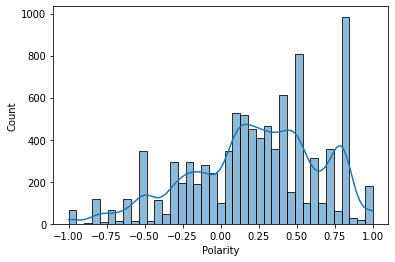

In [51]:
# distplot of polarity of sentiments towards peterObi after removing neutral sentiments
sns.histplot(data=df_peterObi, x='Polarity', kde=True)

# Show plot
plt.show()

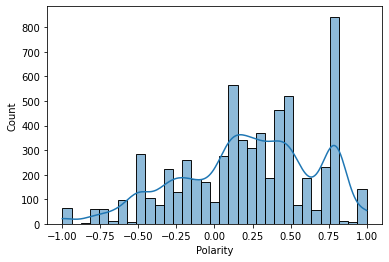

In [52]:
# distplot of polarity of sentiments towards ATIKU after removing neutral sentiments
sns.histplot(data=df_ATIKU, x="Polarity", kde=True)

# Show plot
plt.show()


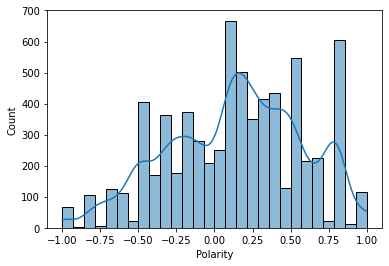

In [53]:
# distplot of polarity of sentiments towards ATIKU after removing neutral sentiments
sns.histplot(data=df_Tinubu, x="Polarity", kde=True)

# Show plot
plt.show()




**From the distplots, it is clear that most social media users have slighty negative or positive sentiments towards the three presidential aspirants**


### Getting The Most Positive and Negative Tweets

In [54]:
# function returning the tweets that were most positive together with ther polarity
def pos_tweets(tweets,title):

    most_pos_text = tweets[tweets['Polarity'] == 1].tweet.head()

    most_pos_pol = tweets[tweets['Polarity'] == 1].Polarity.head()

    return most_pos_text, most_pos_pol 


In [55]:
# most positive tweets for

# PeterObi
pos_tweets(df_peterObi,'Positive tweets for PeterObi')

# Tinubu
pos_tweets(df_Tinubu,'Positive tweets for Tinubu')

# ATIKU
pos_tweets(df_ATIKU,'Positive tweets for ATIKU')


(8465     One of my greatest regret is attending this co...
 24240    @DemolaRewaju Nay. The best person to do it is...
 24776    Why Atiku is the best #DidYouKnow less than 7 ...
 26358    Atiku made a greatest mistake..... https://t.c...
 38289    @NatStructure God abeg. Make people no vote fo...
 Name: tweet, dtype: object,
 8465     1.0
 24240    1.0
 24776    1.0
 26358    1.0
 38289    1.0
 Name: Polarity, dtype: float64)

In [56]:
# function returning the tweets that were most negative together with ther polarity
def neg_tweets(tweets,title):

    most_neg_text = tweets[tweets['Polarity'] == -1].tweet.head()

    most_neg_pol = tweets[tweets['Polarity'] == -1].Polarity.head()

    return most_neg_text, most_neg_pol 


In [57]:
# most negative tweets for

# PeterObi
neg_tweets(df_peterObi,'negative tweets for PeterObi')

# Tinubu
neg_tweets(df_Tinubu,'negative tweets for Tinubu')

# ATIKU
neg_tweets(df_ATIKU,'negative tweets for ATIKU')


(25389    RT @homeware36: @atiku His Excellency Alhaji A...
 25499    @atiku His Excellency Alhaji ATIKU Abubakar co...
 26685    @dino_melaye ASUU will get it worst if Atiku b...
 82181    @jacksonpbn Atiku will be a worst than Tinubu....
 83798    I supported Atiku in 2019 becos the other opti...
 Name: tweet, dtype: object,
 25389   -1.0
 25499   -1.0
 26685   -1.0
 82181   -1.0
 83798   -1.0
 Name: Polarity, dtype: float64)

In [58]:
# function genrating word cloud showing the most popular words for different presidential aspirants
def wordcloud(data,title):
    text = str(data.tweet_clean)
    wc = WordCloud(max_font_size=100,max_words=500,scale=10,relative_scaling=0.6,background_color='white').generate(text)

    plt.figure(figsize=(15,10))
    plt.title(title,{'fontsize':30,'family':'serif'})
    plt.axis('off')
    plt.imshow(wc)


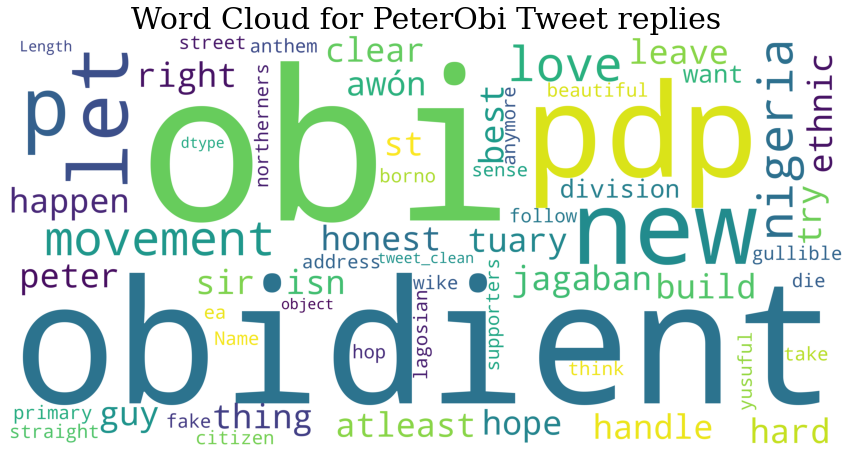

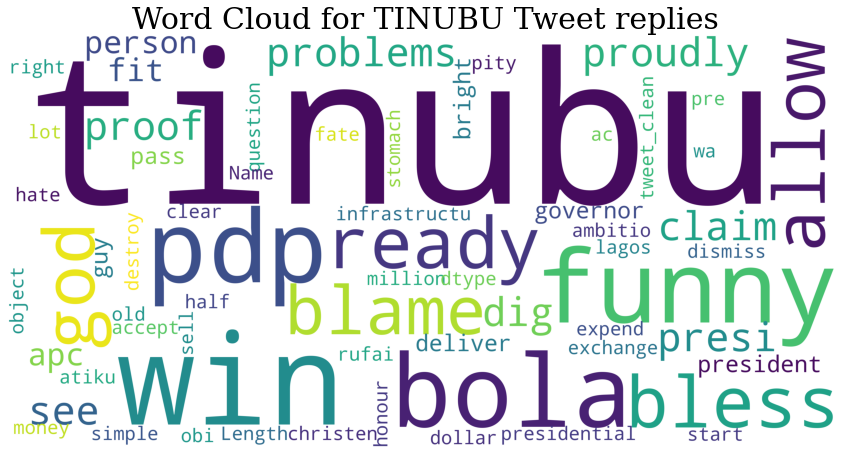

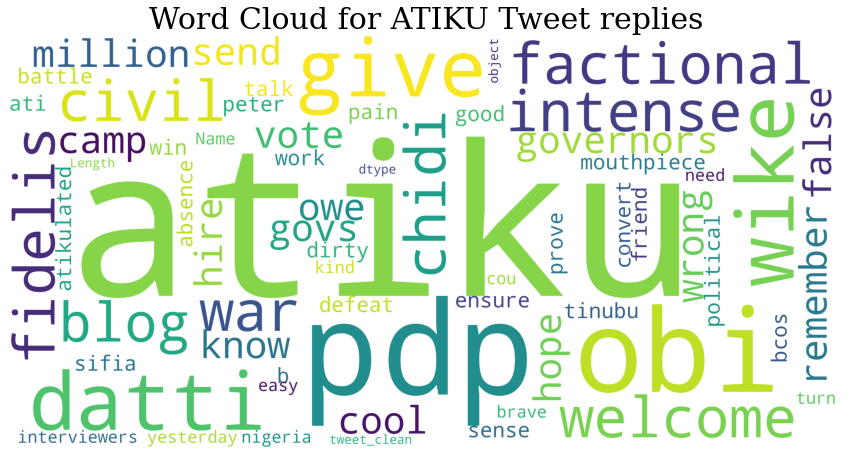

In [59]:
wordcloud(df_peterObi, 'Word Cloud for PeterObi Tweet replies')

wordcloud(df_Tinubu, 'Word Cloud for TINUBU Tweet replies')

wordcloud(df_ATIKU, 'Word Cloud for ATIKU Tweet replies')

### BIVARATE ANALYSIS

In [60]:
# function get percentage of negative and positive sentiments
def pol_percent(subset,total):
    neg_percent = ((subset.groupby('Expressions').count())['Polarity'][0]/total)*100
    pos_percent = ((subset.groupby('Expressions').count())['Polarity'][1]/total)*100
    
    return neg_percent,pos_percent



In [61]:
# get thee length of the various dataframe subsets
records_peterObi = len(df_peterObi)
records_Tinubu = len(df_Tinubu)
records_ATIKU = len(df_ATIKU)

# Sumtotal of all positive, neutral and negative records for the three presidential aspirants
total_records = records_peterObi + records_Tinubu + records_ATIKU + total_neutral


In [62]:
# getting percentage of negative and positive sentiments for the three different presidential aspirants

# peterObi
peterObi_pol_percent = pol_percent(df_peterObi,records_peterObi)
print(peterObi_pol_percent)

# Tinubu
Tinubu_pol_percent = pol_percent(df_Tinubu,records_Tinubu)
print(Tinubu_pol_percent)

# ATIKU
ATIKU_pol_percent = pol_percent(df_ATIKU,records_ATIKU)
print(ATIKU_pol_percent)


(26.27956989247312, 73.72043010752688)
(34.98985801217038, 65.01014198782961)
(27.69014524441668, 72.30985475558333)


In [63]:
# Plotting the distribution of positive and negative tweets per presidential candidate
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
# list of presidential aspirants
candidate = ['PETER OBI','TINUBU', 'ATIKU']

# List of percentage positive and negative sentiments
pos = [peterObi_pol_percent[1], Tinubu_pol_percent[1], ATIKU_pol_percent[1]]
neg = [peterObi_pol_percent[0], Tinubu_pol_percent[0], ATIKU_pol_percent[0]] 

# plot
go.Figure(data=[
    go.Bar(name = 'Positive', x=candidate, y=pos),
    go.Bar(name = 'Negative', x=candidate, y=neg),   
])



### PRESIDENT PREDICTION

In [64]:
# get the favour per presidential aspirant and undecided social media users

# PeterOBI's favour
peterObi_pos = (peterObi_pol_percent[1] + (Tinubu_pol_percent[0] + ATIKU_pol_percent[0])/2) * (records_peterObi/total_records )
print(peterObi_pos,'PETER OBI')

# TINUBU's favour
Tinubu_pos = (Tinubu_pol_percent[1] + (peterObi_pol_percent[0] + ATIKU_pol_percent[0])/2) * (records_Tinubu/total_records )
print(Tinubu_pos, "TINUBU")

# ATIKU's favour
ATIKU_pos = (ATIKU_pol_percent[1] + (peterObi_pol_percent[0] + Tinubu_pol_percent[0])/2) * (records_ATIKU/total_records)
print(ATIKU_pos,'ATIKU')

# Undecided social media users
undecided_pos = (total_neutral/total_records) * 100
print(undecided_pos, 'UNDECIDED')

30.354853210610464 PETER OBI
19.726279574294974 TINUBU
20.478255046499196 ATIKU
29.77196470734435 UNDECIDED


In [65]:
# Creating a dataframe of the presidential outcomes and presidential prediction

# List of presidential aspirants and class of undecided electorate
y = ['peterObi\'s Favour' ,'Tinubu\'s Favour','ATIKU\'s Favour', 'undecided voters']

# List of the three presidential aspirants plus class of undecided electorate
x = [peterObi_pos,Tinubu_pos, ATIKU_pos, undecided_pos]

# dataframe of the elective class and labels of these claases
poll_prediction = pd.DataFrame(list(zip(y, x)),
               columns =['name', 'val'])



In [66]:
# Sorting the values of the presidential prediction in ascending order
fd = poll_prediction.sort_values(by='val', ascending = True)

# Running data in go bar
my_data = [go.Bar( x = fd.name, y = fd.val, orientation = 'h')]

# plot favour per presidential aspirant
go.Figure(go.Bar(y=fd.name,
                 x= fd.val,
                 marker={'color':['rgb(250,100,90,100)','rgb(200,150,200,110)']},
                 orientation='h')).update_layout(title_text='Public Opinion')



In [67]:
# Getting total records of voters ignoring neutral tweets since in general election 
# there is no section of undecided in a ballot paper to predict the most likely 
# outcome of the 2022 elections
total_outcomes = total_records - total_neutral



In [68]:
# peterObi
peterObi_pos = (peterObi_pol_percent[1] + (Tinubu_pol_percent[0] + ATIKU_pol_percent[0])/2) * (records_peterObi/total_outcomes)
print(peterObi_pos,'PETER OBI')

# TINUBU
Tinubu_pos = (Tinubu_pol_percent[1] + (peterObi_pol_percent[0] + ATIKU_pol_percent[0])/2) * (records_Tinubu/total_outcomes )
print(Tinubu_pos, "TINUBU")

# ATIKU FAVOUR
ATIKU_pos = (ATIKU_pol_percent[1] + (peterObi_pol_percent[0] + Tinubu_pol_percent[0])/2) * (records_ATIKU/total_outcomes)
print(ATIKU_pos,'ATIKU')

43.22326985813447 PETER OBI
28.088895684025953 TINUBU
29.159658192290035 ATIKU


In [69]:
# Creating a dataframe of the presidential outcomes and presidential prediction

# List of presidential aspirants and class of undecided electorate
y = ['peterObi\'s Favour' ,'Tinubu\'s Favour','ATIKU\'s Favour']

# List of the three presidential aspirants plus class of undecided electorate
x = [peterObi_pos,Tinubu_pos, ATIKU_pos]

# dataframe of the elective class and labels of these claases
poll_prediction = pd.DataFrame(list(zip(y, x)),
               columns =['name', 'val'])


In [70]:
# Sorting the values of the presidential prediction in ascending order
fd = poll_prediction.sort_values(by='val', ascending = True)

# Running data in go bar
my_data = [go.Bar( x = fd.name, y = fd.val, orientation = 'h')]

# plot favour per presidentail aspirant
go.Figure(go.Bar(y=fd.name,
                 x= fd.val,
                 marker={'color':['rgb(100,200,150)','rgb(90,150,200)']},
                 orientation='h')).update_layout(title_text='Public Opinion')



### RESULT

**General Sentiment Analysis**

Top ten most mentioned words by twitter users were

| NO | WORDS |               count |
|:- | --- | --- |
|0 |	peter obi |	             1815.657522|
|1 	|labour party 	  |        904.714965|
|2 	|apc pdp 	       |       424.481885|
|3 	|vote apc 	        |      265.226837|
|4 	|vote peter 	     |         244.790184|
|5 	|pdp apc 	          |    242.914864|
|6 	|presidential candidate| 	  237.164033|
|7 	|tinubu atiku 	        |  210.356403|
|8 	|atiku abubakar 	     |     200.864822|
|9 	|vote atiku 	          |    194.533429|
|10 	|presidential election |	  189.860390|




**POLITICAL PARTY**

Popularity of various political party in this election over twitter is as follow:



| NO |       party | 	        count|
|:- | --- | --- |
|1 |	APC 	 |       51.329930   | 
|2 |	Labourparty |	32.851953|
|3 	|PDP 	     |   15.818118|


**PRESIDENTIAL ASPIRANT**

**Presidential Aspirant Peter obi has has the highest Trajectory in terms of polarity.
Peter obi has the highest numberof positve and negative sentiments towards him than the other aspirants by twitter users.**

**In terms of mentions , the polarity percentage is as follow**

|No|presidential_aspirant| 	count|
|:-|---|---|
|1| 	peterObi |	54.953493|
|2| 	Tinubu 	 |  23.796763|
|3| 	ATIKU 	  |  21.249744|






## ELECTION PREDICTION


### CONSIDERING  UNDECIDED VOTERS



**By assuming that the positive sentiments a presidential aspirant gets equals to support and the negative sentiments gets equals to support of the opponnent, the following results were obtained IN PERCENTAGE;

|NAME|PERCENTAGE ACCRUED|
| :-|  --- |
|PETER OBI |     30.354853210610464 |
|UNDECIDED   |   29.77196470734435 |
|ATIKU   |       20.478255046499196 |
|TINUBU    |     19.726279574294974 |



### EXCLUDING UNDECIDED VOTERS

|NAME|PERCENTAGE|
|:-|---|
|PETER OBI   |   43.22326985813447 |
|ATIKU|          29.159658192290035 |
|TINUBU  |       28.088895684025953 |



### CONCLUSION



After thorough analysis and scraping of tweets for several days it is visible that Nigeria presidential election is a tough debate on twitter and many users of this media have been ditching out their own personal opinions without holding back

From our analysis , Peter Obi was the most polarized candidate,having the highest number of both positive and negative sentiments

It was also shown from this analyssis that Peter Obi is the most mentioned political figure in the country while Atiku is the least mentioned

From our election prediction results, factoring in neutral voters as undecided voters, it was concluded that a large part of the electorate is still undecided on who to vote for in the forth coming election.

Without the undecided voters, from the analysis, it was concluded that Peter Obi will most likely win the election in the first round with slightly over 43% of the votes.



## DISCLAIMER

This prediction is made using only sentiments sourced from social media hence is not fully representative of Nigeria's electorate